In [15]:
#import packages and formatting statements

import numpy as np
import math
# !pip install matplotlib
from matplotlib import pyplot as plt
# !pip install astropy==5.3
import astropy.io.fits as pyfits
from astropy.table import Table, join, Column
from astropy.wcs import WCS
from astropy.io import ascii
import os
from astropy.coordinates import SkyCoord, Angle
from astropy.nddata import Cutout2D
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from matplotlib.patches import Circle
from reproject import reproject_interp

import sys
sys.path.append('./Python')
from CheckInImage import check_in_image
from AngularSize import findAngSize

plt.rc('text',usetex=False)
fontsize=10
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

ext="HA_FLUX_CORR"

In [16]:
# Compile galaxy and sne data
data = Table.read('../Data/1.GroupedSampleData.csv', format='csv')

data[0:1]

col0,galaxy,distance,gal_ra,gal_dec,pos_ang,incl,nat_res,r_eff,maps_musedap,maps_nat,maps_150,maps_1kpc,maps_HII,maps_irac,maps_CO21,maps_eCO21,maps_CO_fine,maps_eCO_fine,maps_ext,maps_vdisp,maps_HST,JWST200,JWST300,JWST335,JWST360,JWST770,JWST1000,JWST1130,JWST2100,sn_name,sn_type,sn_ra,sn_dec
int64,str7,float64,float64,float64,float64,float64,float64,float64,str71,str58,str64,str63,str50,str40,str72,str73,str72,str73,str36,str32,str41,str101,str101,str101,str101,str101,str102,str102,str102,str82,str50,str127,str132
0,NGC1087,15.85,41.60492,-0.498717,359.1,42.9,0.92,42.091877,../../GalaxyFiles/MUSELargeFiles/MUSE2.2_Nat/NGC1087-0.92asec_MAPS.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_150pc.fits,../../GalaxyFiles/MUSELargeFiles/SFR/copt/NGC1087_sfr_1kpc.fits,../Data/HII_reg_masks/NGC1087_nebulae_mask_V2.fits,../Data/IRAC/ngc1087_irac1_atGauss4.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_150pc_broad_emom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_120pc_broad_mom0.fits,../../GalaxyFiles/ALMACO2-1/ngc1087_12m+7m+tp_co21_120pc_broad_emom0.fits,../Data/SFR_v1/NGC1087_MAPS_sfr.fits,../Data/vdisp/ngc1087_vdisp.fits,../../GalaxyFiles/HST/ngc1087_hst_ha.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F200W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F300M_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F335M_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F360M_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F770W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F1000W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F1130W_atGauss7p5_anchored.fits,../../GalaxyFiles/JWSTLargeFiles/Anchored_8.0_Gauss7.5/ngc1087/ngc1087_F2100W_atGauss7p5_anchored.fits,['SN1995V'],['II'],[41.61152777777777],[-0.4987861111111111]


In [17]:
# get plot information for main image maps for the zooms
def getPlotStuff(gal, img, HSTimg, res, HIIimg, CO21Img, eCO21Img, names, types, ras, decs, dist, ext):
    plots, sigma, wcss, HIImaps, HSTmaps, HIIhst, hdus, dists, resolution = [],[],[],[],[],[],[],[],[]
    wcsHST, hduHST = [],[]
    SNnames, SNtypes, SNras, SNdecs, SNgals = [],[],[],[],[]

    for i in range(len(gal)):
        
        # ungroup and clean SN data
        sn_ra   = [float(x.strip(' []')) for x in ras[i].split(',')]
        sn_dec  = [float(x.strip(' []')) for x in decs[i].split(',')]
        sn_name = [x.strip(' []') for x in names[i].split(',')]
        sn_type = [x.strip(' []') for x in types[i].split(',')]
        
        for j in range(len(sn_name)):
            
            if os.path.isfile(img[i]) and os.path.isfile(HIIimg[i]):

                #get hdu & wcs for MUSE map
                ha_hdu = pyfits.open(img[i])
                hdus.append(ha_hdu)
                ha_map = ha_hdu[ext].data
                w = WCS(ha_hdu[ext].header, naxis=2)
                wcss.append(w)                
                plots.append(ha_map)
                resolution.append(res[i])
                
                #get HII maps
                hii_hdu = pyfits.open(HIIimg[i])
                hii_map = hii_hdu[0].data
                HIImaps.append(hii_map)
                
                #get HST map
                if os.path.isfile(HSTimg[i]):
                    hst_hdu = pyfits.open(HSTimg[i])
                    hst_map = hst_hdu[0].data
                    w = WCS(hst_hdu[0].header, naxis=2)
                    wHST = w      
                    hHST = hst_hdu
#                     hst_map, footprint = reproject_interp(hst_hdu, ha_hdu["HA_FLUX_CORR"].header)
                    hii_hst, footprint = reproject_interp(hii_hdu, hst_hdu[0].header)
                else: 
                    hst_map = np.full_like(ha_map, fill_value = float("NaN"))
                    hii_hst = np.full_like(ha_map, fill_value = float("NaN")) 
                    wHST = float("NaN")
                    hHST = float("NaN")
                
                HSTmaps.append(hst_map)
                HIIhst.append(hii_hst)
                wcsHST.append(w)
                hduHST.append(hHST)

                    
                # get CO contour map 
                if gal[i][0] == "NGC1672":
                    co_img = "../../GalaxyFiles/ALMACO2-1/ngc1672_7m+tp_co21_750pc_broad_mom0.fits"
                    co_err = "../../GalaxyFiles/ALMACO2-1/ngc1672_7m+tp_co21_750pc_broad_emom0.fits"
                else:
                    co_img = CO21Img[i]
                    co_err = eCO21Img[i]
                        
                co_hdu = pyfits.open(co_img)
                eco_hdu = pyfits.open(co_err)

                # reproject onto Halpha map
                co_repro_hdu, footprint = reproject_interp(co_hdu, ha_hdu["HA_FLUX_CORR"].header)
                eco_repro_hdu, footprint = reproject_interp(eco_hdu, ha_hdu["HA_FLUX_CORR"].header)

                # set up CO21 s/n map 
                co_map = co_repro_hdu
                err_map = eco_repro_hdu
                err_map = np.clip(err_map,0.01,np.max(err_map))
                sig_map = co_map / err_map
                sigma.append(sig_map)

                # get rest of data
                SNnames.append(sn_name[j])
                SNtypes.append(sn_type[j])
                SNras.append(sn_ra[j]) 
                SNdecs.append(sn_dec[j])
                SNgals.append(gal[i])
                dists.append(dist[i])

            else:
                #print("no file for ")
                pass

    return(plots, sigma, wcss, HIImaps, HSTmaps, HIIhst, hdus, wcsHST, hduHST, SNnames, SNtypes, SNras, SNdecs, SNgals, dists, resolution)


In [4]:
# set up plot information for MUSE zooms
# set up plots, wcs information, and HII maps for contours.

plots, sigma, wcss, HIImaps, HSTmaps, HIIhst, hdus, wcsHST, hduHST, sn_names, sn_types, sn_ras, sn_decs, sn_gals, dists, res = getPlotStuff(data["galaxy"], data["maps_nat"], data["maps_irac"],data["nat_res"], data["maps_HII"], data["maps_CO21"], data["maps_eCO21"], data["sn_name"], data["sn_type"], data["sn_ra"], data["sn_dec"], data["distance"], ext=ext)


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

/Users/nessmaykerchen/anaconda3/lib/python3.11/site-packages/astropy/wcs/wcsapi/fitswcs.py:346: UserWarning: 'WCS.all_world2pix' failed to converge to the requested accuracy.
After 20 iterations, the solution is diverging at least for one input point.
  warnings.warn(str(e))


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

In [5]:
#set up labels for legends
legendLabels = []

for i in range(len(sn_names)):
    legendlabel = []
    if sn_types[i][0] == 'unclassified':
        legendlabel.append(sn_names[i].strip("'") + ' '  + sn_types[i].strip("'")) 
    else:        
        legendlabel.append(sn_names[i].strip("'") + ' Type '  + sn_types[i].strip("'"))
    legendLabels.append(legendlabel)

# print(legendLabels[0])


In [6]:
resPC = [71,82,109,109,109,109,82,69,69,69,90,90,58,58,58,58,58,57,57,57,57,64,64,64,64,64,64,64,85,85,85,85,85]
len(resPC)

33

/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/3910507210.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)


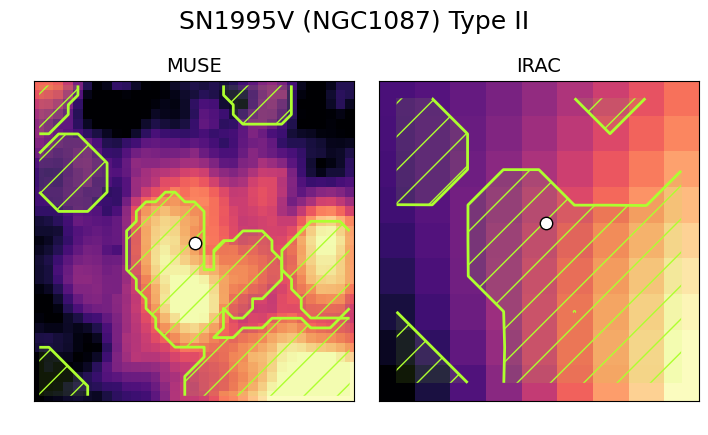

In [20]:
plt.rcParams['hatch.color'] = 'greenyellow'
numPixels, numHIIPixels = [],[]

current_cmap = plt.get_cmap("magma")
current_cmap.set_bad("black")

NUM_SNE= 33

fig, axs = plt.subplots(1,2,figsize=(7,4.5))

# for j in range(len(sn_gals)): # counter to count galaxy maps
for j in range(0,1):
    
    #set up legend label with type classification
    if sn_types[j] != "Unclassified":
        leglab = "Type " + sn_types[j].strip("'")
    else:
        leglab= sn_types[j]
    legStr = str(resPC[j]) + " pc"
    
    #set up data to use astropy's cutout2D to plot subsections of galaxy map
    data = plots[j]
    logData = np.log10(data)
    HIIData = HIImaps[j]
    HSTdata = HSTmaps[j]
#     sigData = sigma[j]
    HIIhstData = HIIhst[j]

    wcs=wcss[j]

    halfBox = findAngSize(500,dists[j])/2. # 500 pc in decimal degrees/2?
    #cutout2D needs skycoord position to carry units
    ra, dec = Angle(sn_ras[j] * u.degree), Angle(sn_decs[j] * u.degree)
    raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
    position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
    size = u.Quantity((findAngSize(500,dists[j]),findAngSize(500,dists[j])), u.degree) #size is size of box in arcsec 
    # make 2D cutout, will assign a new wcs to cutout to keep track of coords
    cutout = Cutout2D(logData, position, size, wcs) 
    # use this new wcs when converting to pixels to add additional details to plot
    xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
    # get HII data for contours
    HIICutout = Cutout2D(HIIData, position, size, wcs)
#     sigCutout = Cutout2D(sigData, position, size, wcs)
    HIICutoutHST = Cutout2D(HIIhstData, position, size, wcsHST[j])
#     sigCutoutHST = Cutout2D(sigData, position, size, wcsHST[j])    
    HSTCutout = Cutout2D(HSTdata, position, size, wcsHST[j])
    xvalHST, yvalHST = HSTCutout.wcs.wcs_world2pix(ra,dec, 0)

    titleStr = sn_names[j].upper().strip("'") + " (" + sn_gals[j].upper() + ") Type " + sn_types[j].strip("'")
            
    # make plot
    fig.suptitle(titleStr, fontsize=18) 
    axs[0].set_title("MUSE", fontsize=14)
    axs[0].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(cutout.data, 5), vmax=np.percentile(cutout.data, 95),interpolation = "nearest", zorder = 0)
    axs[0].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
    axs[0].scatter(xval, yval, color = "white", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
    axs[0].set_ylabel(" ")
    axs[0].set_xlabel(" ")
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].tick_params(axis = "both", direction = "in", length = 0)
    axs[1].set_title("IRAC", fontsize=14)
    axs[1].imshow(np.log10(HSTCutout.data), cmap=current_cmap, aspect="equal", origin = "lower", interpolation = "nearest", zorder = 0)
#     axs[1].imshow(HSTCutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(HSTCutout.data, 5), vmax=np.percentile(HSTCutout.data, 95),interpolation = "nearest", zorder = 0)
    axs[1].scatter(xvalHST, yvalHST, color = "black", marker ="o", s = 60, zorder=2)
    axs[1].scatter(xvalHST, yvalHST, color = "white", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
    axs[1].set_ylabel(" ")
    axs[1].set_xlabel(" ")
    axs[1].set_xticklabels([])
    axs[1].set_yticklabels([])
    axs[1].tick_params(axis = "both", direction = "in", length = 0)
    

    axs[0].contourf(HIICutout.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['/'], zorder = 1, alpha=0.1)
    axs[0].contour(HIICutout.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=2, zorder = 1)
    
    axs[1].contourf(HIICutoutHST.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['/'], zorder = 1, alpha=0.1)
    axs[1].contour(HIICutoutHST.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=2, zorder = 1)

plt.tight_layout(pad=0.4, w_pad=0, h_pad=0.2)
plt.show()
fig.savefig("../Figures/IRAC_MUSE_Comp.png", dpi=300)
plt.close()

0
Type II
0 0 0
1
Type II
0 1 1
2
Type Ia
1 0 2
3
4
Type Ic
1 1 3
5
6
Type II
2 0 4
7
Type Ia
2 1 5
8
Type Ia-02cx
3 0 6
9
Type II


/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:78: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:78: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:23: RuntimeWarning: divide by zero encou

3 1 7
10
Type II
4 0 8
11
Type Ib/c
4 1 9
12
13
Type Ia
5 0 10
14
Type II P
5 1 11
15
Type II
6 0 12
16
17
18
19
20
Type Ic
6 1 13
21
22
23
24
25
26
27
28
Type Ia
7 0 14
29
Type I
7 1 15
30
31
Type Ic
8 0 16
32
Type Ib
8 1 17


/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:78: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:23: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:78: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for item in leg.legendHandles:
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/737396608.py:23: RuntimeWarning: divide by zero encou

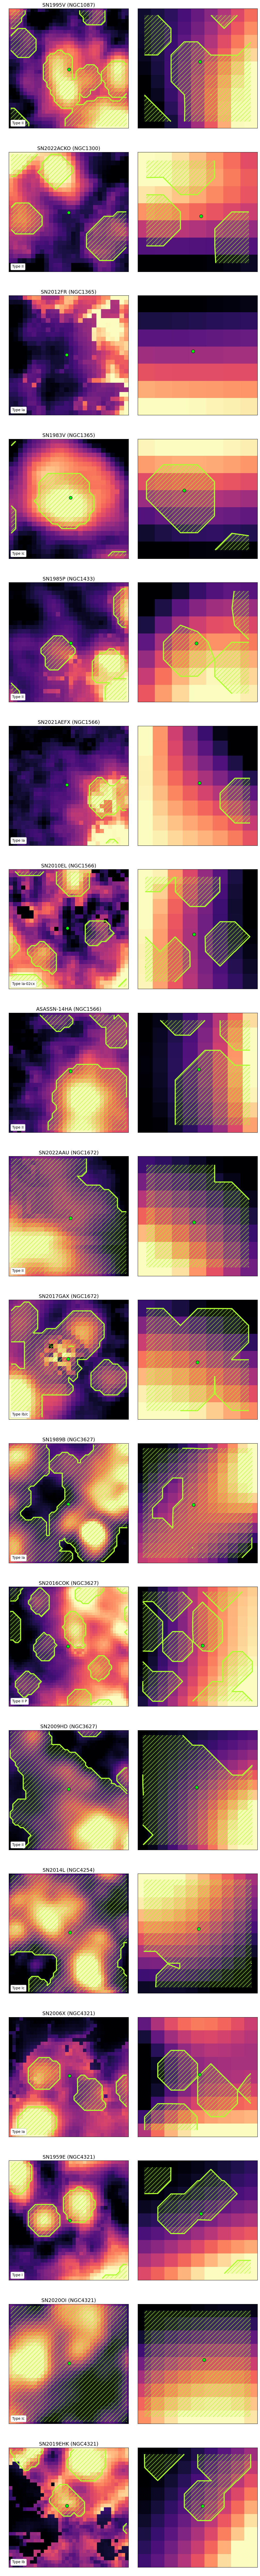

In [8]:

comp = [0,1,2,4,6,7,8,9,10,11,13,14,15,20,28,29,31,32]

fig, axs = plt.subplots(len(comp),2,figsize=(10,100))

l,n,m,p=0,0,0,0
PLOTS_PER_ROW = 2

for j in range(len(sn_gals)): # counter to count galaxy maps
# for j in range(0,1):
    print(j)
    if j in comp:

        #set up legend label with type classification
#         if sn_types[j] != "Unclassified":
        leglab = "Type " + sn_types[j].strip("'")
#         else:
#             leglab= sn_types[j]
        print(leglab)
        legStr = str(resPC[j]) + " pc"

        #set up data to use astropy's cutout2D to plot subsections of galaxy map
        data = plots[j]
        logData = np.log10(data)
        HIIData = HIImaps[j]
        HSTdata = HSTmaps[j]
    #     sigData = sigma[j]
        HIIhstData = HIIhst[j]

        wcs=wcss[j]

        halfBox = findAngSize(500,dists[j])/2. # 500 pc in decimal degrees/2?
        #cutout2D needs skycoord position to carry units
        ra, dec = Angle(sn_ras[j] * u.degree), Angle(sn_decs[j] * u.degree)
        raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
        position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
        size = u.Quantity((findAngSize(500,dists[j]),findAngSize(500,dists[j])), u.degree) #size is size of box in arcsec 
        # make 2D cutout, will assign a new wcs to cutout to keep track of coords
        cutout = Cutout2D(logData, position, size, wcs) 
        # use this new wcs when converting to pixels to add additional details to plot
        xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
        # get HII data for contours
        HIICutout = Cutout2D(HIIData, position, size, wcs)
    #     sigCutout = Cutout2D(sigData, position, size, wcs)
        HIICutoutHST = Cutout2D(HIIhstData, position, size, wcsHST[j])
    #     sigCutoutHST = Cutout2D(sigData, position, size, wcsHST[j])    
        HSTCutout = Cutout2D(HSTdata, position, size, wcsHST[j])
        xvalHST, yvalHST = HSTCutout.wcs.wcs_world2pix(ra,dec, 0)

        titleStr = sn_names[j].upper().strip("'") + " (" + sn_gals[j].upper() + ")"

        # make plot
        axs[l][0].set_title(titleStr, fontsize=14)      
        axs[l][0].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(cutout.data, 5), vmax=np.percentile(cutout.data, 95),interpolation = "nearest", zorder = 0)
        axs[l][0].scatter(xval, yval, color = "black", marker ="o", s = 60, zorder=2)
        axs[l][0].scatter(xval, yval, color = "lime", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
        axs[l][0].set_ylabel(" ")
        axs[l][0].set_xlabel(" ")
        axs[l][0].set_xticklabels([])
        axs[l][0].set_yticklabels([])
        axs[l][0].tick_params(axis = "both", direction = "in", length = 0)
        
        axs[l][1].imshow(HSTCutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(HSTCutout.data, 5), vmax=np.percentile(HSTCutout.data, 95),interpolation = "nearest", zorder = 0)
        axs[l][1].scatter(xvalHST, yvalHST, color = "black", marker ="o", s = 60, zorder=2)
        axs[l][1].scatter(xvalHST, yvalHST, color = "lime", marker = "o", s = 80, edgecolor="black",zorder = 2)
        axs[l][1].set_ylabel(" ")
        axs[l][1].set_xlabel(" ")
        axs[l][1].set_xticklabels([])
        axs[l][1].set_yticklabels([])
        axs[l][1].tick_params(axis = "both", direction = "in", length = 0)


        axs[l][0].contourf(HIICutout.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=0.1)
        axs[l][0].contour(HIICutout.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=3, zorder = 1)
        axs[l][1].contourf(HIICutoutHST.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['//'], zorder = 1, alpha=0.1)
        axs[l][1].contour(HIICutoutHST.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=3, zorder = 1)
        print(m,n,p)
        leg = axs[p][0].legend(handlelength=0, handletextpad=0, loc="lower left", facecolor='white', framealpha=1.0)
        for item in leg.legendHandles:
            item.set_visible(False)
        l+=1

        n+=1
        if n%PLOTS_PER_ROW==0:
            m+=1
            n=0
        p +=1
    else:pass

# plt.subplots_adjust(left = 0.1, bottom = 0.1, right = 0.99, top = 0.9, wspace = 0.1, hspace = 0.1)
plt.tight_layout(pad=0.5, w_pad=.8, h_pad=1.0)
plt.show()
fig.savefig("../Figures/MUSE_IRAC_Zooms_500pc.png", dpi=300)
plt.close()

/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/133089626.py:17: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/133089626.py:17: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/133089626.py:17: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/133089626.py:17: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/133089626.py:17: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy5ffbm80000gn/T/ipykernel_13612/133089626.py:17: RuntimeWarning: divide by zero encountered in log10
  logData = np.log10(data)
/var/folders/db/q76d94y56zscb4zzdy

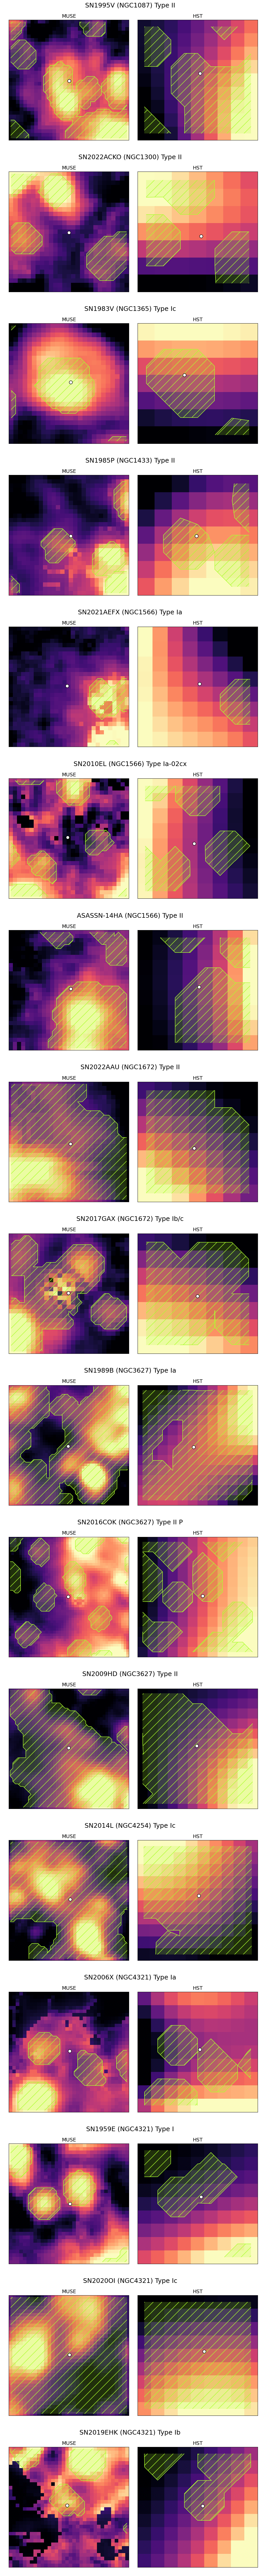

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(10,100))

i=0

comp = [0,1,4,6,7,8,9,10,11,13,14,15,20,28,29,31,32]


# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(comp), ncols=1)

for row, subfig in enumerate(subfigs):
    titleStr = sn_names[comp[i]].upper().strip("'") + " (" + sn_gals[comp[i]].upper() + ") Type " + sn_types[comp[i]].strip("'")
    subfig.suptitle(titleStr, fontsize=18)
    
    #set up data to use astropy's cutout2D to plot subsections of galaxy map
    data = plots[comp[i]]
    logData = np.log10(data)
    HIIData = HIImaps[comp[i]]
    HSTdata = HSTmaps[comp[i]]
    HIIhstData = HIIhst[comp[i]]

    wcs=wcss[comp[i]]

    halfBox = findAngSize(500,dists[comp[i]])/2. # 500 pc in decimal degrees/2?
    #cutout2D needs skycoord position to carry units
    ra, dec = Angle(sn_ras[comp[i]] * u.degree), Angle(sn_decs[comp[i]] * u.degree)
    raRad, decRad  = ra.radian * u.rad, dec.radian * u.rad    
    position = SkyCoord(raRad, decRad) #position is center, use ra & dec of SN location
    size = u.Quantity((findAngSize(500,dists[comp[i]]),findAngSize(500,dists[comp[i]])), u.degree) #size is size of box in arcsec 
    # make 2D cutout, will assign a new wcs to cutout to keep track of coords
    cutout = Cutout2D(logData, position, size, wcs) 
    # use this new wcs when converting to pixels to add additional details to plot
    xval, yval = cutout.wcs.wcs_world2pix(ra,dec, 0)
    # get HII data for contours
    HIICutout = Cutout2D(HIIData, position, size, wcs)
    HIICutoutHST = Cutout2D(HIIhstData, position, size, wcsHST[comp[i]])
    HSTCutout = Cutout2D(HSTdata, position, size, wcsHST[comp[i]])
    xvalHST, yvalHST = HSTCutout.wcs.wcs_world2pix(ra,dec, 0)


    # create 1x3 subplots per subfig
    ax = subfig.subplots(nrows=1, ncols=2)
    for col in ax:
        ax[0].imshow(cutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(cutout.data, 5), vmax=np.percentile(cutout.data, 95),interpolation = "nearest", zorder = 0)
        ax[0].scatter(xval, yval, color = "white", marker ="o", s = 60, zorder=2)
        ax[0].scatter(xval, yval, color = "white", marker = "o", s = 80, edgecolor="black",zorder = 2, label=leglab)
        ax[0].set_title("MUSE", fontsize=14) 
        ax[0].set_ylabel(" ")
        ax[0].set_xlabel(" ")
        ax[0].set_xticklabels([])
        ax[0].set_yticklabels([])
        ax[0].tick_params(axis = "both", direction = "in", length = 0)
        
        ax[1].imshow(HSTCutout.data, cmap=current_cmap, aspect="equal", origin = "lower", vmin=np.percentile(HSTCutout.data, 5), vmax=np.percentile(HSTCutout.data, 95),interpolation = "nearest", zorder = 0)
        ax[1].scatter(xvalHST, yvalHST, color = "white", marker ="o", s = 60, zorder=2)
        ax[1].scatter(xvalHST, yvalHST, color = "white", marker = "o", s = 80, edgecolor="black",zorder = 2)
        ax[1].set_title("HST", fontsize=14)
        ax[1].set_ylabel(" ")
        ax[1].set_xlabel(" ")
        ax[1].set_xticklabels([])
        ax[1].set_yticklabels([])
        ax[1].tick_params(axis = "both", direction = "in", length = 0)


        ax[0].contourf(HIICutout.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['/'], zorder = 1, alpha=0.1)
        ax[0].contour(HIICutout.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=1, zorder = 1)
        ax[1].contourf(HIICutoutHST.data, [3,1000000], colors = ["greenyellow"], linestyles = ("-"), hatches=['/'], zorder = 1, alpha=0.1)
        ax[1].contour(HIICutoutHST.data, [3], colors = ["greenyellow"], linestyles = ("-"), linewidths=1, zorder = 1)
        
        
        
    i+=1
# plt.tight_layout(pad=0.5, w_pad=.8, h_pad=1.0)
plt.show()
fig.savefig("../Figures/MUSE_IRAC_Zooms_500pc.png", dpi=300)
plt.close()

In [10]:
print(HIICutout.shape)

(34, 34)


In [11]:
print(HSTCutout.shape)

(9, 9)


In [12]:
leglab

'Type Ib'

In [13]:
len(sn_types)

33

In [14]:
len(sn_gals)

33